In [1]:
# import
import warnings
import cv2
import pickle
import math
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import pyautogui as pg

from time import time, sleep
from tqdm import tqdm
from glob import glob
from pprint import pprint
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from threading import Thread
from matplotlib import pyplot as plt
from line_profiler import LineProfiler


class Samples_container:
    imgs_real_part = glob("C:/Users/Haya/OneDrive/DevlopingProjects/RoboCup_Cam/Assets/real/part/*.jpg")
    imgs_color_black = glob("C:/Users/Haya/OneDrive/DevlopingProjects/RoboCup_Cam/Assets/real/color/black/*.jpg")
    imgs_color_white = glob("C:/Users/Haya/OneDrive/DevlopingProjects/RoboCup_Cam/Assets/real/color/white/*.jpg")
    imgs_color_green = glob("C:/Users/Haya/OneDrive/DevlopingProjects/RoboCup_Cam/Assets/real/color/green/*.jpg")
    imgs_color_red = glob("C:/Users/Haya/OneDrive/DevlopingProjects/RoboCup_Cam/Assets/real/color/red/*.jpg")
    imgs_entire = glob("C:/Users/Haya/OneDrive/DevlopingProjects/RoboCup_Cam/Assets/real/entire/*.jpg")
    imgs_part = glob("C:/Users/Haya/OneDrive/DevlopingProjects/RoboCup_Cam/Assets/real/part/*.jpg")


In [2]:
# initial settings

print("OpenCV", cv2.__version__)
print("numpy", np.__version__)
print("pandas", pd.__version__)
print("Pyautogui", pg.__version__)
print("Scikit-learn", sklearn.__version__)

warnings.simplefilter('ignore')  # すべての警告を非表示にする


def SaveInstances(instance, path):
    '''
    PickleモジュールのWrapper
    instanceのオブジェクトをpathで指定したファイルパスに保存する。
    '''
    with open(path, mode='wb') as file:
        pickle.dump(instance, file, protocol=2)


def LoadInstances(path):
    '''
    PickleモジュールのWrapper
    pathに保存されているpickle形式のファイルをオブジェクトとして読み込む。
    '''
    with open(path, 'rb') as ins:
        return pickle.load(ins)


samples = Samples_container()


OpenCV 4.5.4
numpy 1.20.1
pandas 1.2.4
Pyautogui 0.9.53
Scikit-learn 0.24.1


In [3]:
# prepare samples of color

def prepare_bgr(paths, code):
    temp = np.reshape([[[[
        [pixel for pixel in line]
        for line in frame]
        for frame in cv2.resize(cv2.imread(path), (640, 360))]
    ]for path in paths
    ], newshape=(-1, 3)
    ).astype(np.int64)
    temp_code = np.ones(len(temp)) * code
    return np.insert(temp, 3, temp_code, axis=1)


color_white = prepare_bgr(samples.imgs_color_white, 0)
color_black = prepare_bgr(samples.imgs_color_black, 1)
color_green = prepare_bgr(samples.imgs_color_green, 2)
color_red = prepare_bgr(samples.imgs_color_red, 3)

color_all = np.concatenate([color_black, color_green, color_white, color_red, ])

df = pd.DataFrame([
    np.append("{:,}".format(len(color_black)), np.average(color_black[:2], axis=0).astype(np.int32)),
    np.append("{:,}".format(len(color_green)), np.average(color_green[:2], axis=0).astype(np.int32)),
    np.append("{:,}".format(len(color_white)), np.average(color_white[:2], axis=0).astype(np.int32)),
    np.append("{:,}".format(len(color_red)), np.average(color_red[:2], axis=0).astype(np.int32)),
], index=["Black", "Green", "White", "Red"], columns=["Samples", "Ave. B", "Ave. G", "Ave. R", "Linked code"])

df = df.sort_values("Linked code")
df


,Samples,Ave. B,Ave. G,Ave. R,Linked code
White,"460,800",154,174,185,0
Black,"691,200",3,3,3,1
Green,"691,200",135,154,4,2
Red,"460,800",39,50,172,3


In [4]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from matplotlib.colors import ListedColormap
# 色識別モデル製作のための比較実験


X_train, X_test, y_train, y_test = train_test_split(
    color_all[:, :-1],
    color_all[:, -1:],
    stratify=color_all[:, -1:],  # テストに使うデータを階層化する
    test_size=0.8,  # テストに使う割合
)

m_SVC = SVC().fit(X_train, y_train)
m_LinearSVC = LinearSVC().fit(X_train, y_train)
m_GaussianNB = GaussianNB().fit(X_train, y_train)
m_MLPClassifier = MLPClassifier().fit(X_train, y_train)
m_KNeighborsClassifier = KNeighborsClassifier().fit(X_train, y_train)
m_DecisionTreeClassifier = DecisionTreeClassifier().fit(X_train, y_train)
m_AdaBoostClassifier = AdaBoostClassifier().fit(X_train, y_train)
m_RandomForestClassifier = RandomForestClassifier().fit(X_train, y_train)
m_QuadraticDiscriminantAnalysis = QuadraticDiscriminantAnalysis().fit(X_train, y_train)

In [5]:
def prof():
    for _ in tqdm(range(10)):
        m_SVC.predict(X_test)
        m_LinearSVC.predict(X_test)
        m_GaussianNB.predict(X_test)
        m_MLPClassifier.predict(X_test)
        m_KNeighborsClassifier.predict(X_test)
        m_DecisionTreeClassifier.predict(X_test)
        m_AdaBoostClassifier.predict(X_test)
        m_RandomForestClassifier.predict(X_test)
        m_QuadraticDiscriminantAnalysis.predict(X_test)


pr = LineProfiler()
pr.add_function(prof)
pr.runcall(prof)
pr.print_stats(output_unit=1)

100%|██████████| 10/10 [1:22:18<00:00, 493.89s/it]

Timer unit: 1 s

Total time: 4938.91 s
File: C:\Users\Haya\AppData\Local\Temp/ipykernel_1376/3847377433.py
Function: prof at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def prof():
     2        11          0.0      0.0      0.0      for _ in tqdm(range(10)):
     3        10       3188.3    318.8     64.6          m_SVC.predict(X_test)
     4        10          0.8      0.1      0.0          m_LinearSVC.predict(X_test)
     5        10          3.8      0.4      0.1          m_GaussianNB.predict(X_test)
     6        10         14.1      1.4      0.3          m_MLPClassifier.predict(X_test)
     7        10       1495.8    149.6     30.3          m_KNeighborsClassifier.predict(X_test)
     8        10          1.2      0.1      0.0          m_DecisionTreeClassifier.predict(X_test)
     9        10        107.2     10.7      2.2          m_AdaBoostClassifier.predict(X_test)
    10        10        123.9     12.

Color recognize model >>  SVC()
Timer: 57.78855sec
Frame: 480px 640px


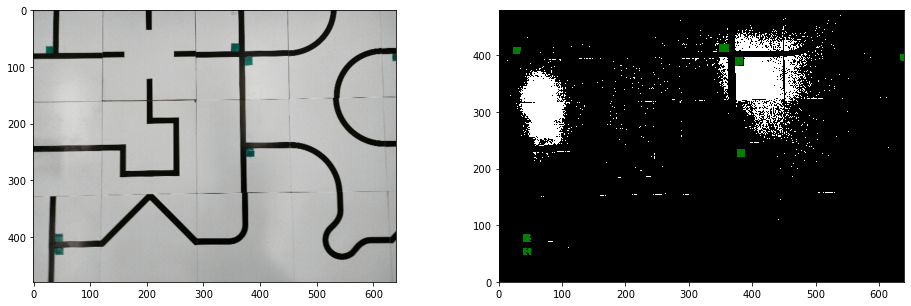

Color recognize model >>  LinearSVC()
Timer: 0.01696sec
Frame: 480px 640px


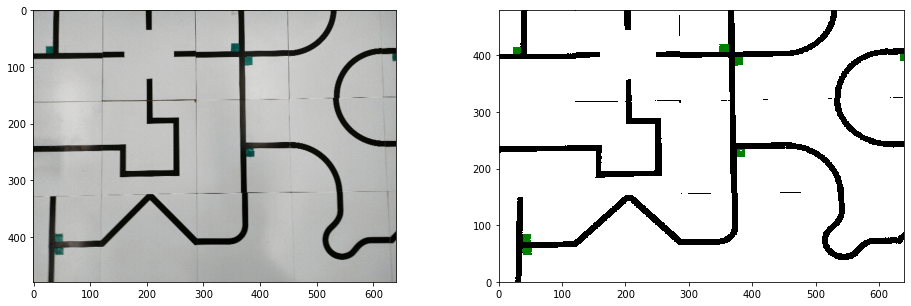

Color recognize model >>  GaussianNB()
Timer: 0.07583sec
Frame: 480px 640px


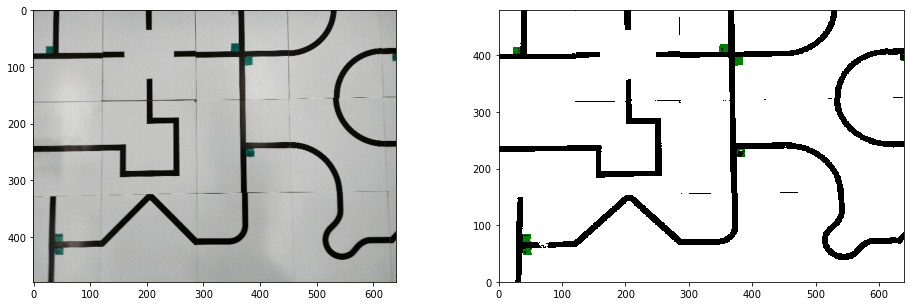

Color recognize model >>  MLPClassifier()
Timer: 0.24032sec
Frame: 480px 640px


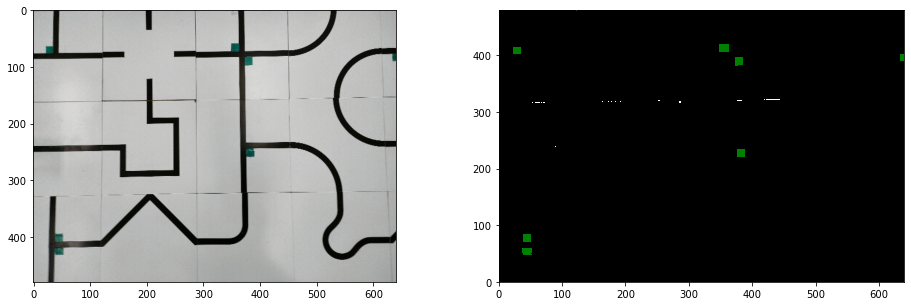

Color recognize model >>  KNeighborsClassifier()
Timer: 6.50362sec
Frame: 480px 640px


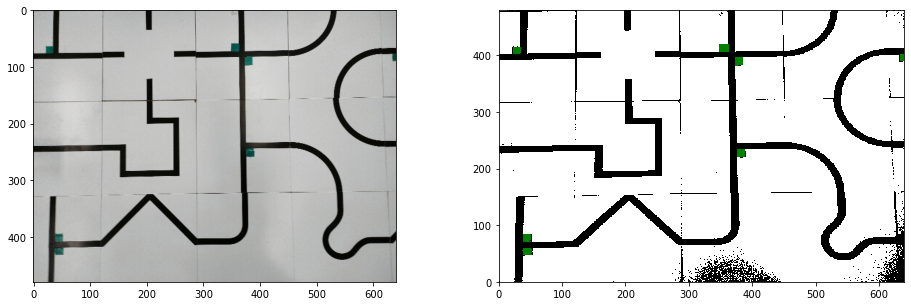

Color recognize model >>  DecisionTreeClassifier()
Timer: 0.04189sec
Frame: 480px 640px


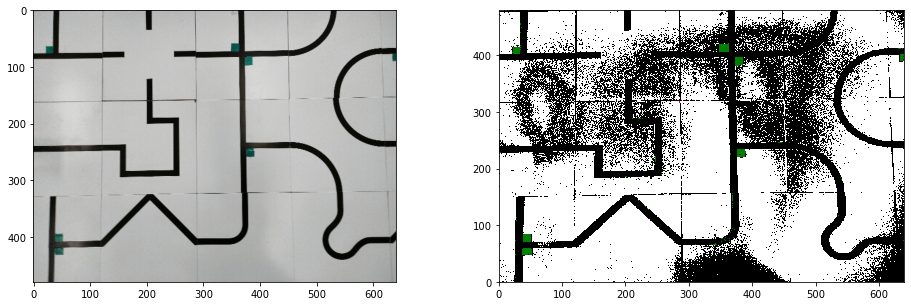

Color recognize model >>  AdaBoostClassifier()
Timer: 2.78559sec
Frame: 480px 640px


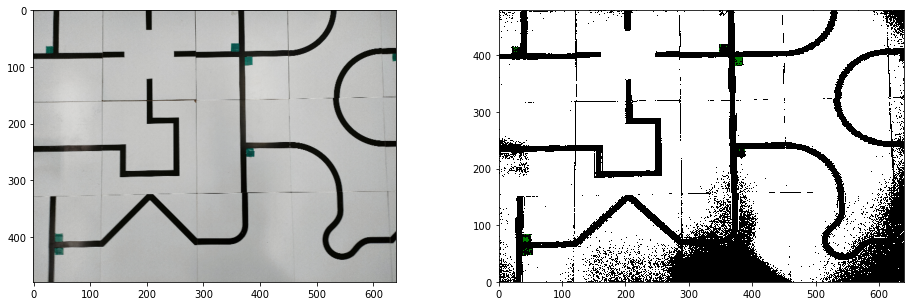

Color recognize model >>  RandomForestClassifier()
Timer: 4.31448sec
Frame: 480px 640px


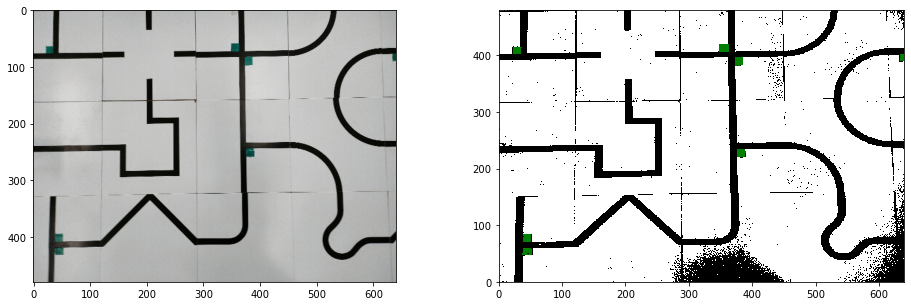

Color recognize model >>  QuadraticDiscriminantAnalysis()
Timer: 0.07480sec
Frame: 480px 640px


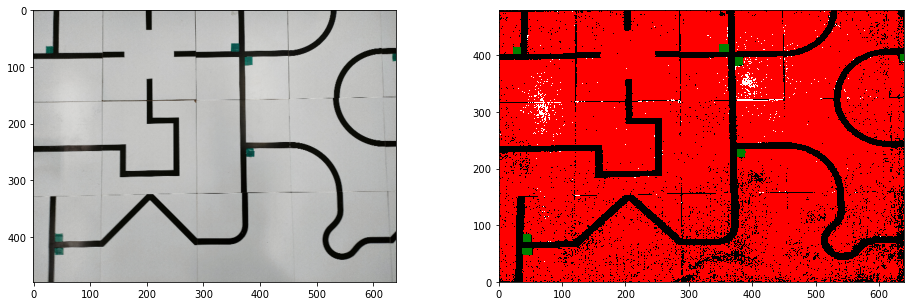

In [6]:
colors = df.index
cmap = ListedColormap(colors, name="custom")

for col_model in [m_SVC, m_LinearSVC, m_GaussianNB, m_MLPClassifier, m_KNeighborsClassifier, m_DecisionTreeClassifier, m_AdaBoostClassifier, m_RandomForestClassifier, m_QuadraticDiscriminantAnalysis]:
    print("Color recognize model >> ", col_model)

    # 写真を読み込む
    entire_img = cv2.imread(samples.imgs_entire[0])
    entire_img = cv2.resize(entire_img, (640, 480))
    entire_height, entire_width = entire_img.shape[:2]

    # 色を識別する
    timer_begin = time()
    entire_img_result = np.array([col_model.predict(row) for row in reversed(entire_img)])
    print("Timer: {:,.5f}sec\nFrame: {:,}px {:,}px".format(time() - timer_begin, entire_height, entire_width))

    # 表示用に調整する
    entire_img_result[0][0] = int(df.loc["Black"]["Linked code"])  # black
    entire_img_result[0][1] = int(df.loc["Green"]["Linked code"])  # green
    entire_img_result[0][2] = int(df.loc["White"]["Linked code"])  # white
    entire_img_result[0][3] = int(df.loc["Red"]["Linked code"])  # red
    entire_img_result += 1

    # 表示
    plt.figure(figsize=(16, 5))
    plt.subplot(121)
    plt.imshow(cv2.cvtColor(entire_img, cv2.COLOR_BGR2RGB))  # -> 注意
    plt.subplot(122)
    plt.pcolormesh(entire_img_result, cmap=cmap)
    plt.show()
